Generate some validation videos random, download them from the server and then use them to visualize the results.

In [1]:
import random
import os
import numpy as np
from work.dataset.activitynet import ActivityNetDataset

dataset = ActivityNetDataset(
    videos_path='../dataset/videos.json',
    labels_path='../dataset/labels.txt'
)
videos = dataset.get_subset_videos('validation')
videos = random.sample(videos, 8)

examples = []
for v in videos:
    file_dir = os.path.join('../downloads/features/', v.features_file_name)
    if not os.path.isfile(file_dir):
        os.system('scp imatge:~/work/datasets/ActivityNet/v1.3/features/{} ../downloads/features/'.format(v.features_file_name))
    features = np.load(file_dir)
    examples.append((v, features))

Load the trained model with its weigths

In [2]:
from keras.layers import Input, BatchNormalization, LSTM, TimeDistributed, Dense, merge
from keras.models import Model

input_features_a = Input(batch_shape=(1, 1, 4096,), name='features')
input_normalized_a = BatchNormalization(mode=1)(input_features_a)
lstm1_a = LSTM(512, return_sequences=True, stateful=True, name='lstm1')(input_normalized_a)
lstm2_a = LSTM(512, return_sequences=True, stateful=True, name='lstm2')(lstm1_a)
output_a = TimeDistributed(Dense(201, activation='softmax'), name='fc')(lstm2_a)
model_def = Model(input=input_features_a, output=output_a)
model_def.load_weights('../work/scripts/training/lstm_activity_classification/model_snapshot/lstm_activity_classification_02_e100.hdf5')
model_def.summary()
model_def.compile(loss='categorical_crossentropy', optimizer='rmsprop')

Using Theano backend.


____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
features (InputLayer)              (1, 1, 4096)        0                                            
____________________________________________________________________________________________________
batchnormalization_1 (BatchNormaliz(1, 1, 4096)        8192        features[0][0]                   
____________________________________________________________________________________________________
lstm1 (LSTM)                       (1, 1, 512)         9439232     batchnormalization_1[0][0]       
____________________________________________________________________________________________________
lstm2 (LSTM)                       (1, 1, 512)         2099200     lstm1[0][0]                      
___________________________________________________________________________________________

In [3]:
input_features = Input(batch_shape=(1, 1, 4096,), name='features')
input_normalized = BatchNormalization()(input_features)
previous_output = Input(batch_shape=(1, 1, 202,), name='prev_output')
merging = merge([input_normalized, previous_output], mode='concat', concat_axis=-1)
lstm1 = LSTM(512, return_sequences=True, stateful=True, name='lstm1')(merging)
lstm2 = LSTM(512, return_sequences=True, stateful=True, name='lstm2')(lstm1)
output = TimeDistributed(Dense(201, activation='softmax'), name='fc')(lstm2)
model_feed = Model(input=[input_features, previous_output], output=output)

model_feed.load_weights('../work/scripts/training/lstm_activity_classification_feedback/model_snapshot/lstm_activity_classification_feedback_02_e100.hdf5')
model_feed.summary()
model_feed.compile(loss='categorical_crossentropy', optimizer='rmsprop')

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
features (InputLayer)              (1, 1, 4096)        0                                            
____________________________________________________________________________________________________
batchnormalization_2 (BatchNormaliz(1, 1, 4096)        8192        features[0][0]                   
____________________________________________________________________________________________________
prev_output (InputLayer)           (1, 1, 202)         0                                            
____________________________________________________________________________________________________
merge_1 (Merge)                    (1, 1, 4298)        0           batchnormalization_2[0][0]       
                                                                   prev_output[0][0]       

Extract the predictions for each video and print the scoring

In [4]:
predictions_def = []
for v, features in examples:
    nb_instances = features.shape[0]
    X = features.reshape((nb_instances, 1, 4096))
    model_def.reset_states()
    prediction = model_def.predict(X, batch_size=1)
    prediction = prediction.reshape(nb_instances, 201)
    class_prediction = np.argmax(prediction, axis=1)
    predictions_def.append((v, prediction, class_prediction))

/Users/Alberto/Development/DeepLearning/frameworks/Keras/keras/keras/backend/theano_backend.py:514: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: keras_learning_phase.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  **kwargs)


In [5]:
predictions_feed = []
for v, features in examples:
    nb_instances = features.shape[0]
    X = features.reshape((nb_instances, 1, 4096))
    
    prediction = np.zeros((nb_instances, 201))
    X_prev_output = np.zeros((1, 202))
    X_prev_output[0,201] = 1
    model_feed.reset_states()
    for i in range(nb_instances):
        X_features = X[i,:,:].reshape(1, 1, 4096)
        X_prev_output = X_prev_output.reshape(1, 1, 202)
        next_output = model_feed.predict_on_batch(
            {'features': X_features,
            'prev_output': X_prev_output}
        )
        prediction[i,:] = next_output[0,:]
        X_prev_output = np.zeros((1, 202))
        X_prev_output[0,:201] = next_output[0,:]
    class_prediction = np.argmax(prediction, axis=1)
    predictions_feed.append((v, prediction, class_prediction))

Print the global classification results

Video ID: AR6_PW1um-I		Main Activity: Rollerblading
Default Model
0.4854	Longboarding
0.4065	Rollerblading
0.0599	Elliptical trainer
Model with Feedback
0.9904	Longboarding
0.0085	Rollerblading
0.0010	Tennis serve with ball bouncing


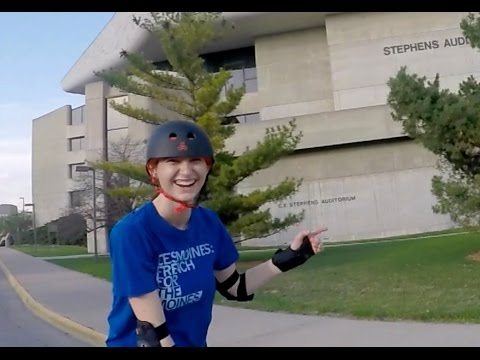



Video ID: MsalIjwP3no		Main Activity: Plastering
Default Model
0.6589	Plastering
0.1985	Doing a powerbomb
0.0642	Painting fence
Model with Feedback
0.9476	Capoeira
0.0183	Plastering
0.0098	Futsal


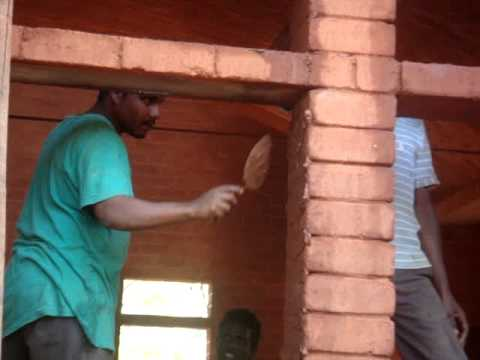



Video ID: esNQZCjMZaM		Main Activity: Archery
Default Model
0.4258	Snatch
0.2648	Archery
0.1729	Doing fencing
Model with Feedback
0.3957	Archery
0.1905	Javelin throw
0.1217	Canoeing


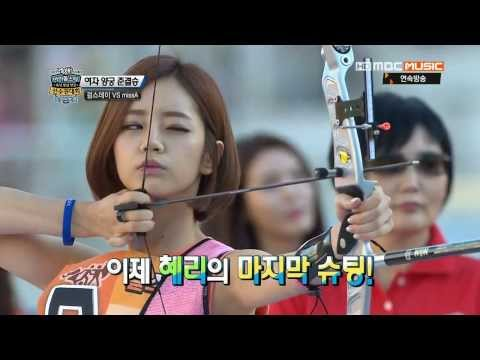



Video ID: 9fw8ODTEso4		Main Activity: Beach soccer
Default Model
0.9987	Beach soccer
0.0004	Wrapping presents
0.0003	Futsal
Model with Feedback
0.6453	Playing beach volleyball
0.3536	Beach soccer
0.0006	Putting on shoes


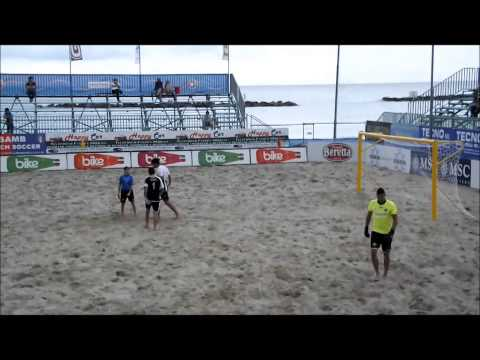



Video ID: m1aF1CVo-s8		Main Activity: Elliptical trainer
Default Model
0.8472	Spinning
0.0785	Using the rowing machine
0.0417	Assembling bicycle
Model with Feedback
0.9968	Elliptical trainer
0.0012	Fixing bicycle
0.0007	Playing accordion


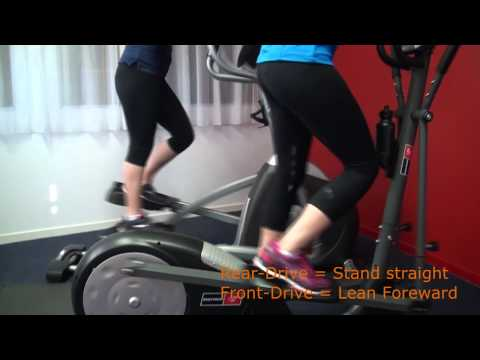



Video ID: GvJxJf4m6_M		Main Activity: Putting on shoes
Default Model
0.9638	Spinning
0.0211	Throwing darts
0.0122	Decorating the Christmas tree
Model with Feedback
0.5262	Elliptical trainer
0.1128	Playing drums
0.0904	Spinning


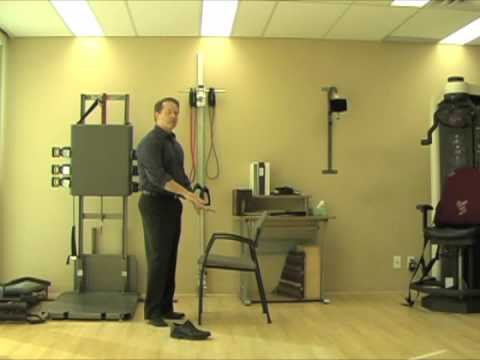



Video ID: 5E2OdhrgG8s		Main Activity: Playing harmonica
Default Model
0.4643	Mixing drinks
0.1946	Tango
0.0745	Drinking beer
Model with Feedback
0.7711	Playing harmonica
0.1098	Smoking a cigarette
0.0768	Playing violin


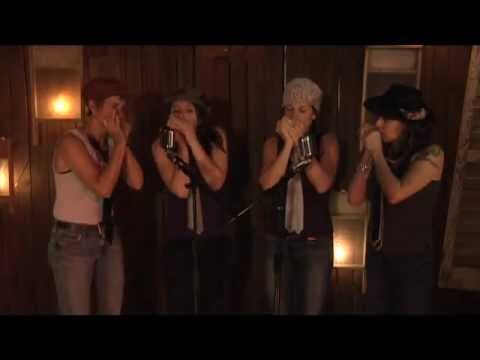



Video ID: oS7Twj3Pou0		Main Activity: Hopscotch
Default Model
0.5398	Fun sliding down
0.0506	Mooping floor
0.0498	Drinking coffee
Model with Feedback
0.1677	Walking the dog
0.1294	Playing saxophone
0.1041	Bathing dog


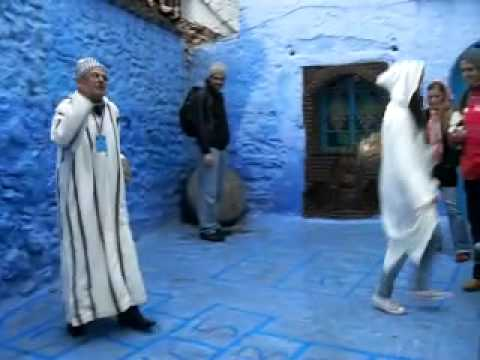

In [6]:
from IPython.display import YouTubeVideo, display

for prediction_def, prediction_feed in zip(predictions_def, predictions_feed):
    v, prediction_d, class_prediction_d = prediction_def
    _, prediction_f, class_prediction_f = prediction_feed
    print('Video ID: {}\t\tMain Activity: {}'.format(v.video_id, v.get_activity()))
    labels = ('Default Model', 'Model with Feedback')
    for prediction, label in zip((prediction_d, prediction_f), labels):
        print(label)
        class_means = np.mean(prediction, axis=0)
        top_3 = np.argsort(class_means[1:])[::-1][:3] + 1
        scores = class_means[top_3]/np.sum(class_means[1:])
        for index, score in zip(top_3, scores):
            if score == 0.:
                continue
            label = dataset.labels[index][1]
            print('{:.4f}\t{}'.format(score, label))
    vid = YouTubeVideo(v.video_id)
    display(vid)
    print('\n')
    
    

Now show the temporal prediction for the activity happening at the video.

Video ID: AR6_PW1um-I
Main Activity: Rollerblading


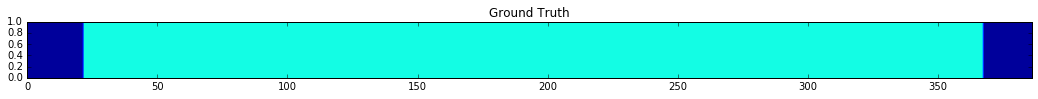

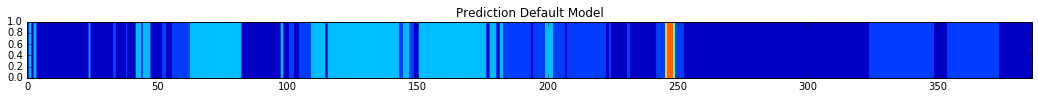

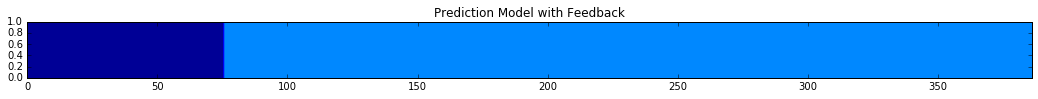



Video ID: MsalIjwP3no
Main Activity: Plastering


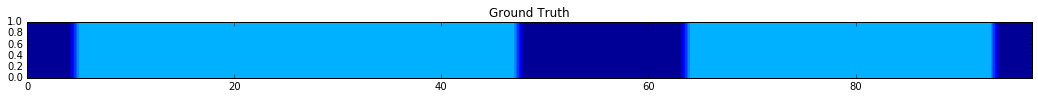

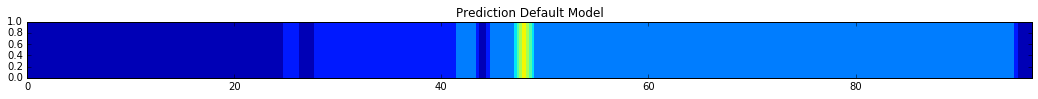

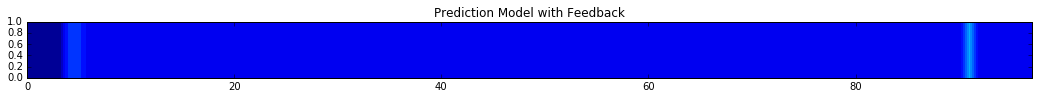



Video ID: esNQZCjMZaM
Main Activity: Archery


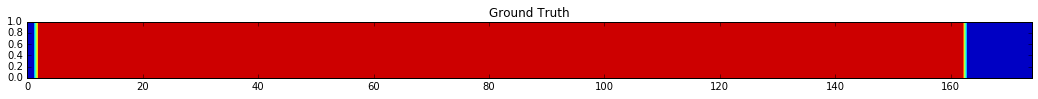

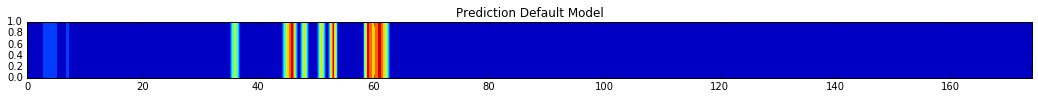

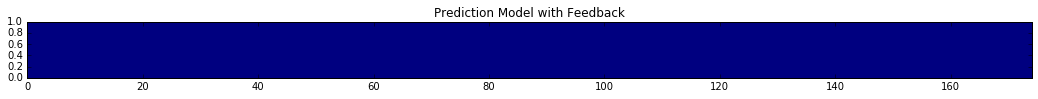



Video ID: 9fw8ODTEso4
Main Activity: Beach soccer


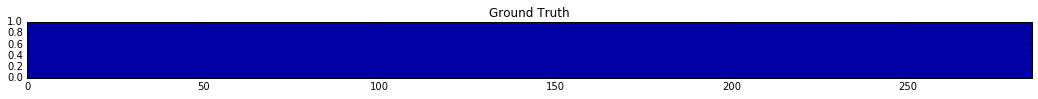

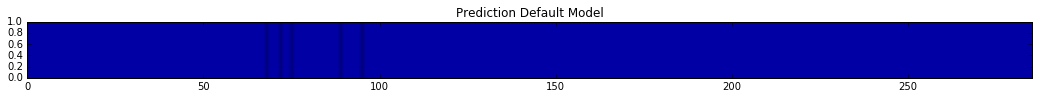

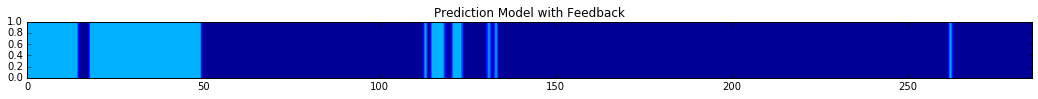



Video ID: m1aF1CVo-s8
Main Activity: Elliptical trainer


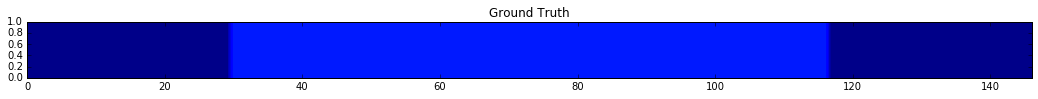

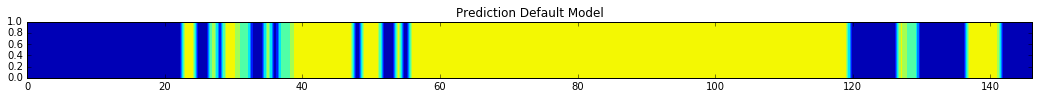

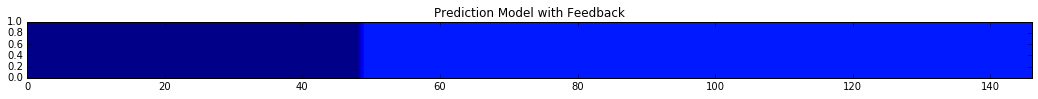



Video ID: GvJxJf4m6_M
Main Activity: Putting on shoes


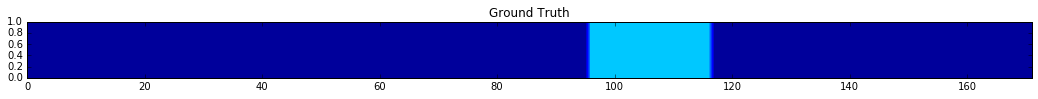

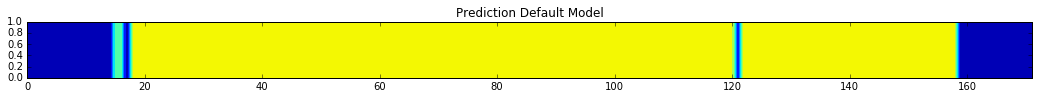

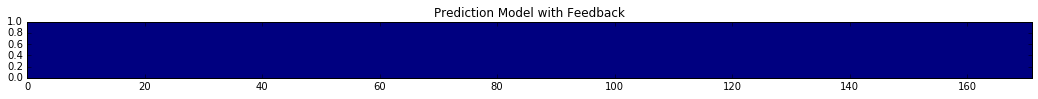



Video ID: 5E2OdhrgG8s
Main Activity: Playing harmonica


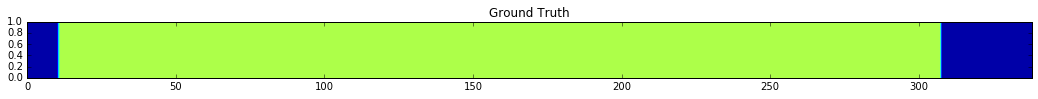

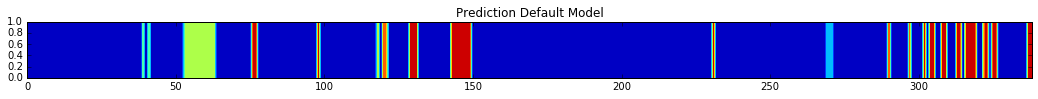

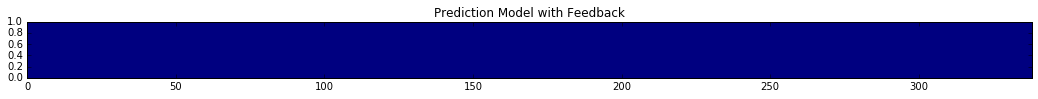



Video ID: oS7Twj3Pou0
Main Activity: Hopscotch


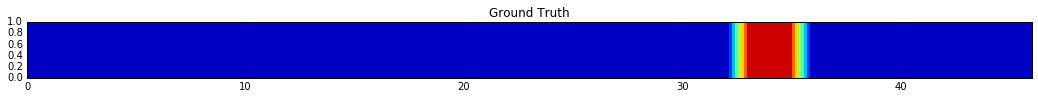

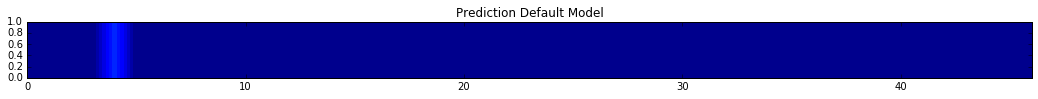

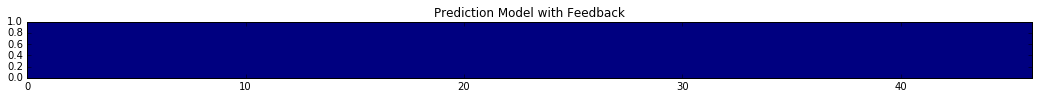

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
normalize = matplotlib.colors.Normalize(vmin=0, vmax=201)

for prediction_d, prediction_f in zip(predictions_def, predictions_feed):
    v, _, class_prediction_d = prediction_d
    _, _, class_prediction_f = prediction_f
    v.get_video_instances(16, 0)
    ground_truth = np.array([instance.output for instance in v.instances])
    nb_instances = len(v.instances)
    
    print('Video ID: {}\nMain Activity: {}'.format(v.video_id, v.get_activity()))
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(ground_truth, (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Ground Truth')
    plt.show()
    
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(class_prediction_d, (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Prediction Default Model')
    plt.show()
    
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(class_prediction_f, (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Prediction Model with Feedback')
    plt.show()

    print('\n')

Video ID: AR6_PW1um-I
Main Activity: Rollerblading
Default Model
0.4854	Longboarding
0.4065	Rollerblading
0.0599	Elliptical trainer
Model with Feedback
0.9904	Longboarding
0.0085	Rollerblading
0.0010	Tennis serve with ball bouncing


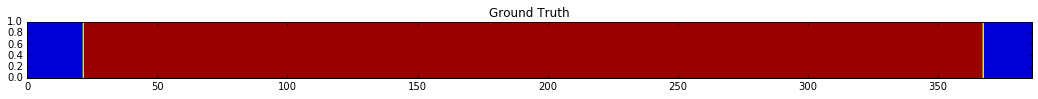

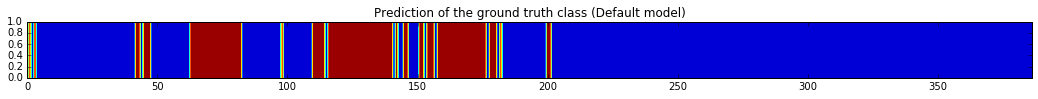

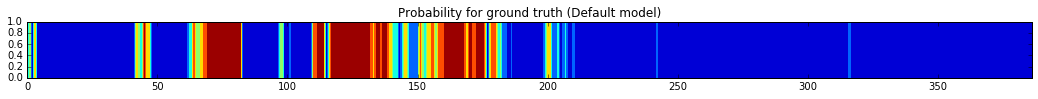

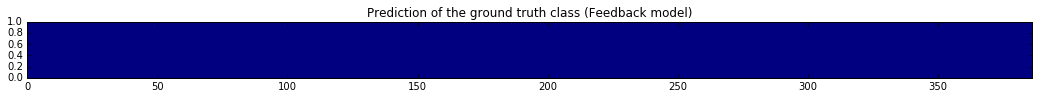

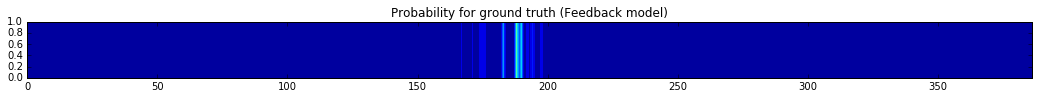



Video ID: MsalIjwP3no
Main Activity: Plastering
Default Model
0.6589	Plastering
0.1985	Doing a powerbomb
0.0642	Painting fence
Model with Feedback
0.9476	Capoeira
0.0183	Plastering
0.0098	Futsal


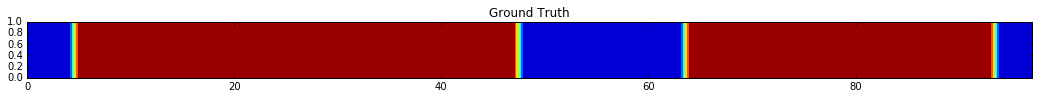

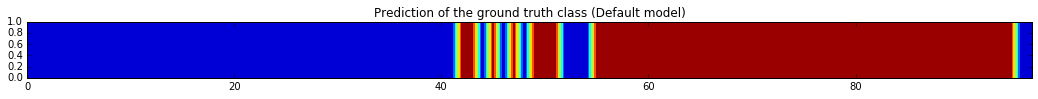

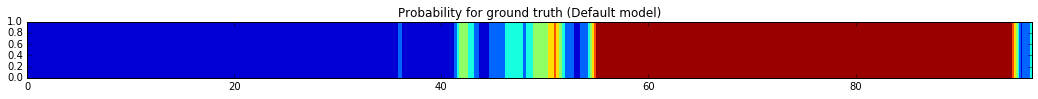

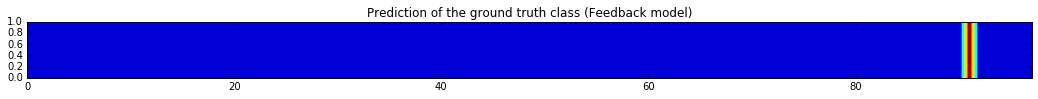

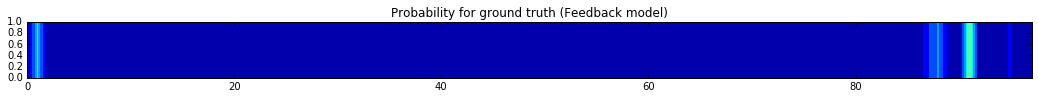



Video ID: esNQZCjMZaM
Main Activity: Archery
Default Model
0.4258	Snatch
0.2648	Archery
0.1729	Doing fencing
Model with Feedback
0.3957	Archery
0.1905	Javelin throw
0.1217	Canoeing


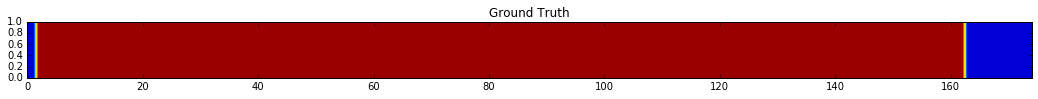

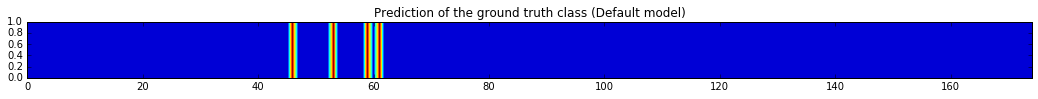

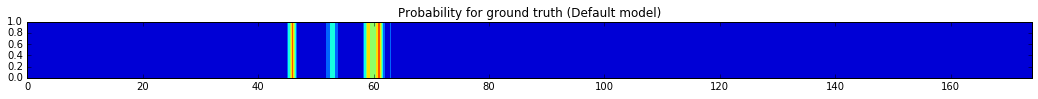

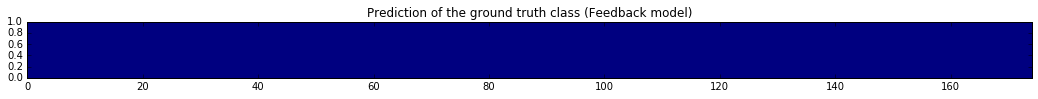

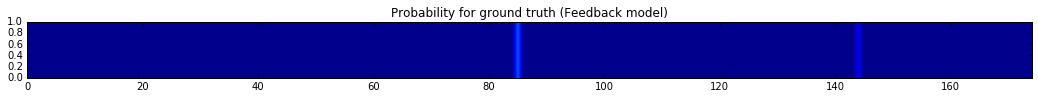



Video ID: 9fw8ODTEso4
Main Activity: Beach soccer
Default Model
0.9987	Beach soccer
0.0004	Wrapping presents
0.0003	Futsal
Model with Feedback
0.6453	Playing beach volleyball
0.3536	Beach soccer
0.0006	Putting on shoes


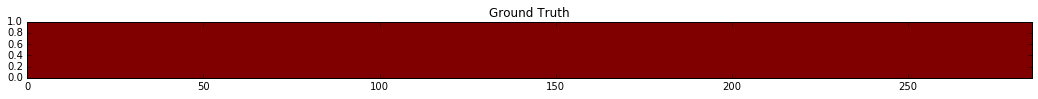

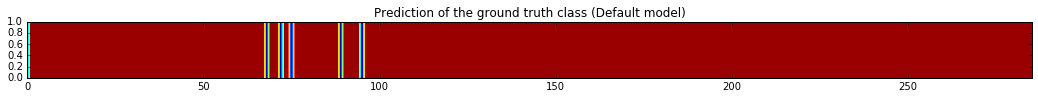

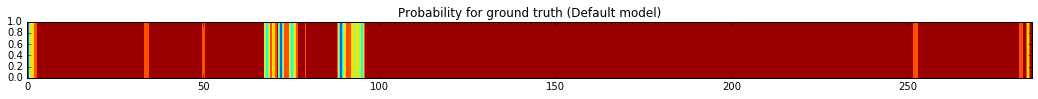

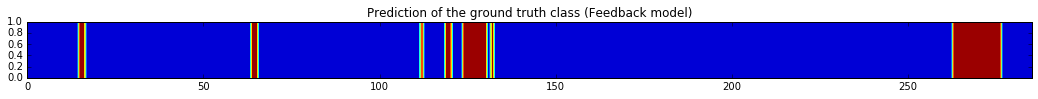

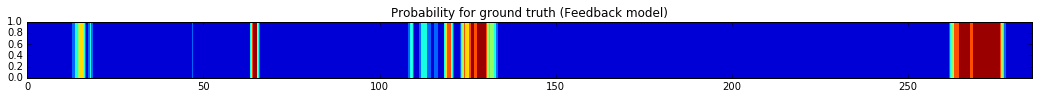



Video ID: m1aF1CVo-s8
Main Activity: Elliptical trainer
Default Model
0.8472	Spinning
0.0785	Using the rowing machine
0.0417	Assembling bicycle
Model with Feedback
0.9968	Elliptical trainer
0.0012	Fixing bicycle
0.0007	Playing accordion


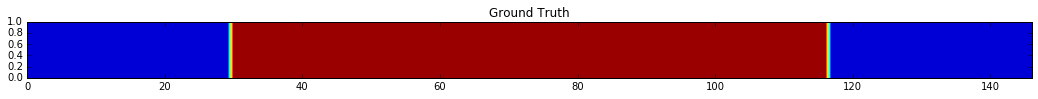

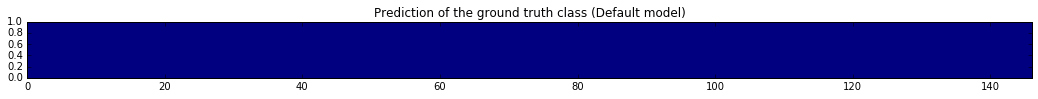

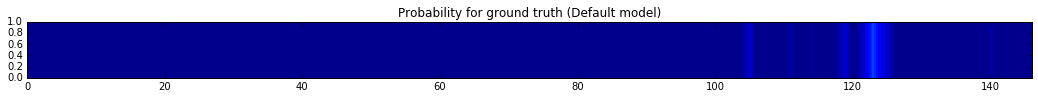

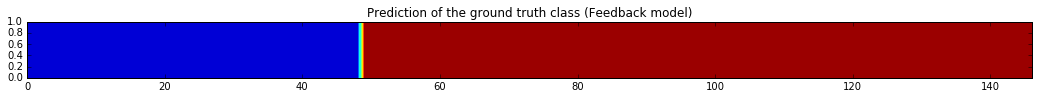

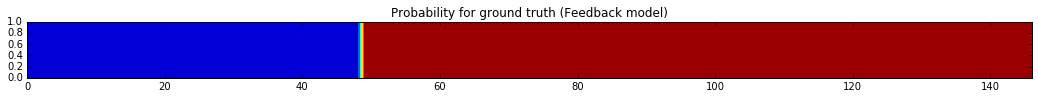



Video ID: GvJxJf4m6_M
Main Activity: Putting on shoes
Default Model
0.9638	Spinning
0.0211	Throwing darts
0.0122	Decorating the Christmas tree
Model with Feedback
0.5262	Elliptical trainer
0.1128	Playing drums
0.0904	Spinning


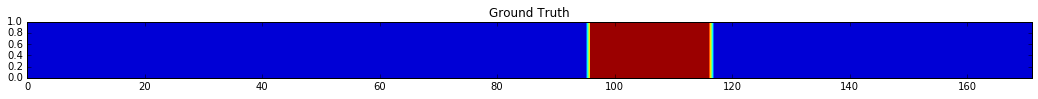

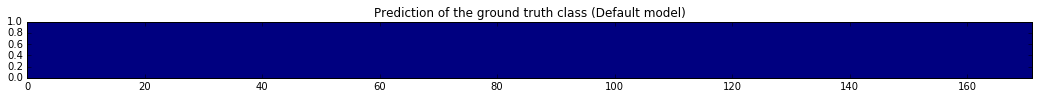

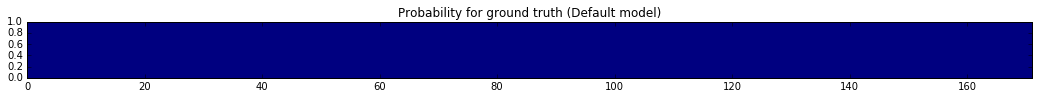

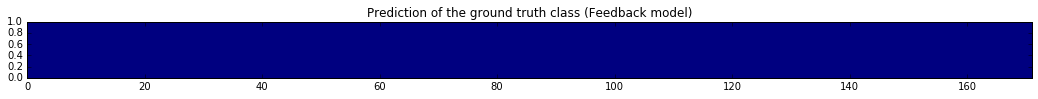

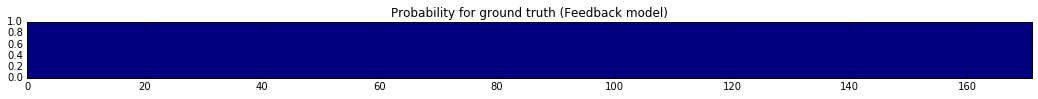



Video ID: 5E2OdhrgG8s
Main Activity: Playing harmonica
Default Model
0.4643	Mixing drinks
0.1946	Tango
0.0745	Drinking beer
Model with Feedback
0.7711	Playing harmonica
0.1098	Smoking a cigarette
0.0768	Playing violin


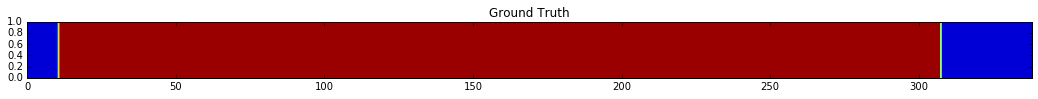

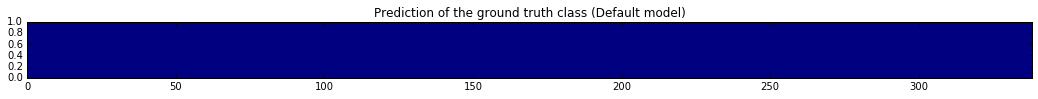

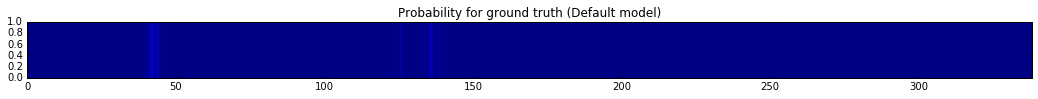

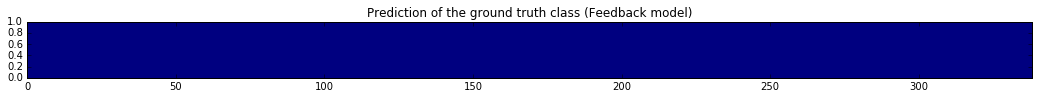

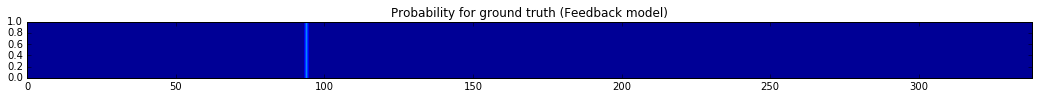



Video ID: oS7Twj3Pou0
Main Activity: Hopscotch
Default Model
0.5398	Fun sliding down
0.0506	Mooping floor
0.0498	Drinking coffee
Model with Feedback
0.1677	Walking the dog
0.1294	Playing saxophone
0.1041	Bathing dog


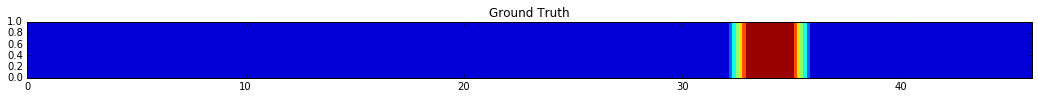

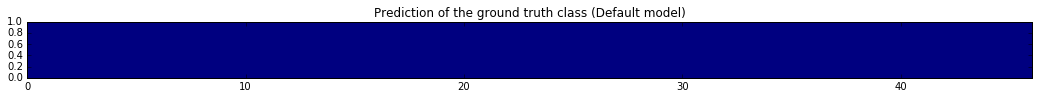

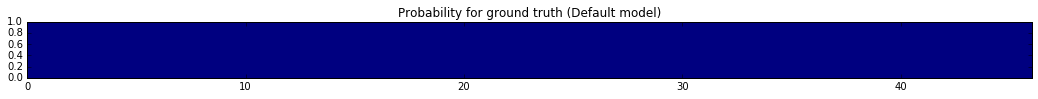

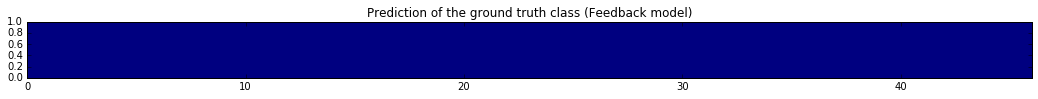

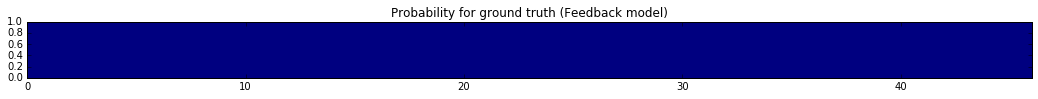

In [8]:
normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)

for prediction_def, prediction_feed in zip(predictions_def, predictions_feed):
    v, prediction_d, class_prediction_d = prediction_def
    _, prediction_f, class_prediction_f = prediction_feed
    v.get_video_instances(16, 0)
    ground_truth = np.array([instance.output for instance in v.instances])
    nb_instances = len(v.instances)
    output_index = dataset.get_output_index(v.label)
    
    print('Video ID: {}\nMain Activity: {}'.format(v.video_id, v.get_activity()))

    labels = ('Default Model', 'Model with Feedback')
    for prediction, label in zip((prediction_d, prediction_f), labels):
        print(label)
        class_means = np.mean(prediction, axis=0)
        top_3 = np.argsort(class_means[1:])[::-1][:3] + 1
        scores = class_means[top_3]/np.sum(class_means[1:])
        for index, score in zip(top_3, scores):
            if score == 0.:
                continue
            label = dataset.labels[index][1]
            print('{:.4f}\t{}'.format(score, label))
    
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(ground_truth/output_index, (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Ground Truth')
    plt.show()
    
    # print only the positions that predicted the global ground truth category
    temp_d = np.zeros((nb_instances))
    temp_d[class_prediction_d==output_index] = 1
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(temp_d, (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Prediction of the ground truth class (Default model)')
    plt.show()
    
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(prediction_d[:,output_index], (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Probability for ground truth (Default model)')
    plt.show()
    
    # print only the positions that predicted the global ground truth category
    temp_f = np.zeros((nb_instances))
    temp_f[class_prediction_f==output_index] = 1
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(temp_f, (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Prediction of the ground truth class (Feedback model)')
    plt.show()
    
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(prediction_f[:,output_index], (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Probability for ground truth (Feedback model)')
    plt.show()

    print('\n')